In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'
import torch
from PIL import Image
from diffusers import FluxControlNetPipeline, FluxControlNetModel, FluxPriorReduxPipeline, FluxFillPipeline
from diffusers.models import FluxMultiControlNetModel
from controlnet_aux import OpenposeDetector
from detector.groundingdino_sam import GroundingdinoSam
from utils import image_grid, down_size
from controlnet_aux import CannyDetector

In [ ]:
base_model = 'black-forest-labs/FLUX.1-dev'
controlnet_model_union = '/amax/hchuz/hfd_models/FLUX.1-dev-ControlNet-Union-Pro'
dino_checkpoint = '/amax/hchuz/OMG-master/checkpoint/GroundingDINO'
sam_checkpoint = '/amax/hchuz/OMG-master/checkpoint/sam/sam_vit_h_4b8939.pth'
offload = True
seed = 42
controlnet_union = FluxControlNetModel.from_pretrained(controlnet_model_union, torch_dtype=torch.bfloat16)
controlnet = FluxMultiControlNetModel([controlnet_union]) # we always recommend loading via FluxMultiControlNetModel
pipe_prior_redux = FluxPriorReduxPipeline.from_pretrained("black-forest-labs/FLUX.1-Redux-dev", torch_dtype=torch.bfloat16).to('cuda')
pipe = FluxControlNetPipeline.from_pretrained(base_model, controlnet=controlnet, torch_dtype=torch.bfloat16)
if offload:
    pipe.enable_model_cpu_offload()
else:
    pipe.to("cuda")
groundingdino_sam = GroundingdinoSam(dino_checkpoint, sam_checkpoint)
processor = CannyDetector()
pass

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


final text_encoder_type: bert-base-uncased


Model loaded from groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


In [3]:
control_image = Image.open('temp/double_canny.png')
control_image.size

(574, 1024)

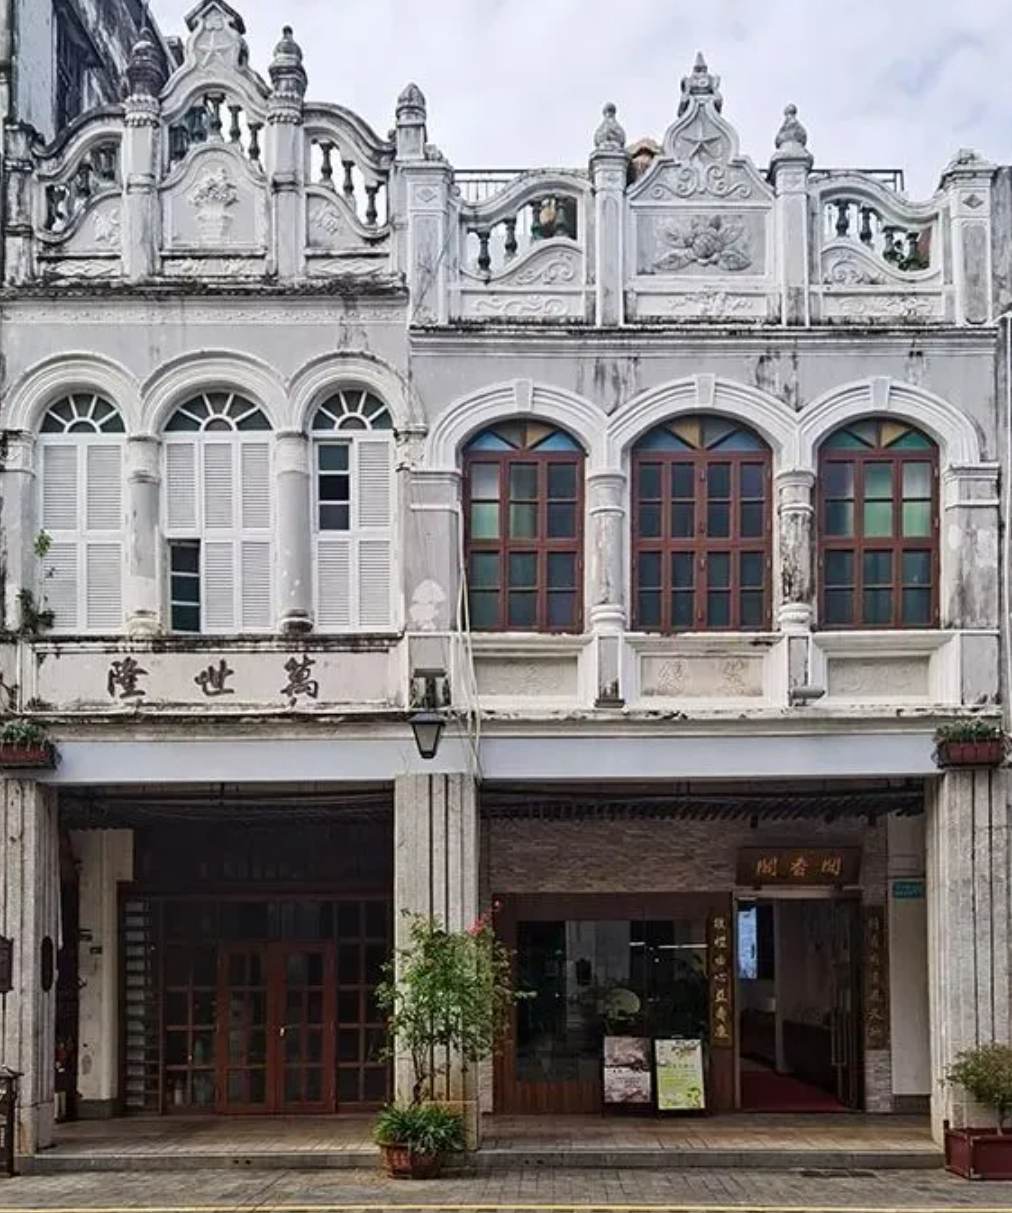

In [4]:
global_style_image = Image.open('/amax/hchuz/architectural_heritage/相似的几个2/Snipaste_2023-02-21_13-33-51.png')
global_style_image

In [5]:
#prompt = "an architectural heritage"
control_mode = 0
width, height = control_image.size

`height` and `width` have to be divisible by 16 but are 1024 and 574. Dimensions will be resized accordingly


  0%|          | 0/20 [00:00<?, ?it/s]

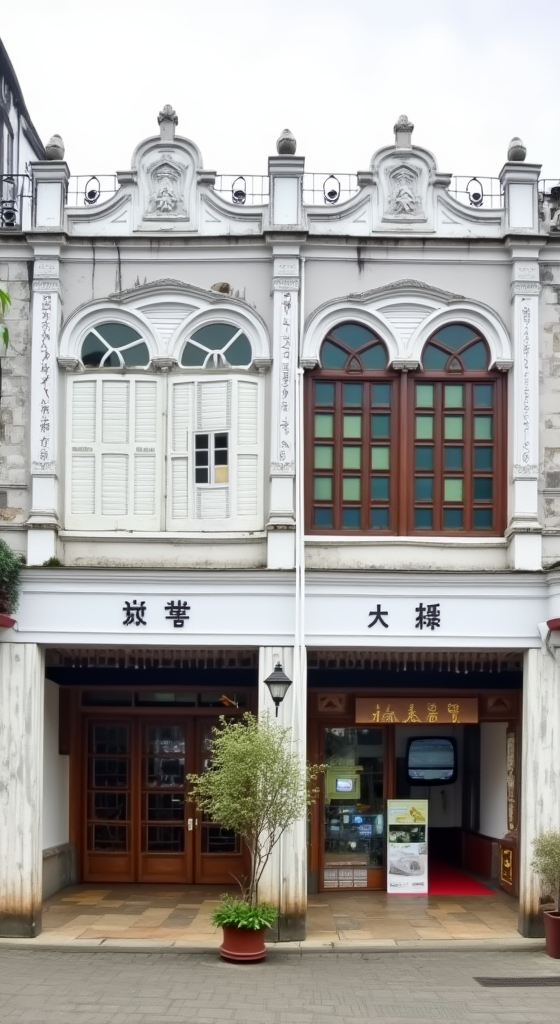

In [6]:
global_style_input = pipe_prior_redux(global_style_image)
image_stage1 = pipe(
    #prompt, 
    **global_style_input,
    control_image=[control_image],
    control_mode=[control_mode],
    width=width,
    height=height,
    controlnet_conditioning_scale=[0.4],
    num_inference_steps=20, 
    guidance_scale=3.5,
    generator=torch.manual_seed(seed),
).images[0]
image_stage1

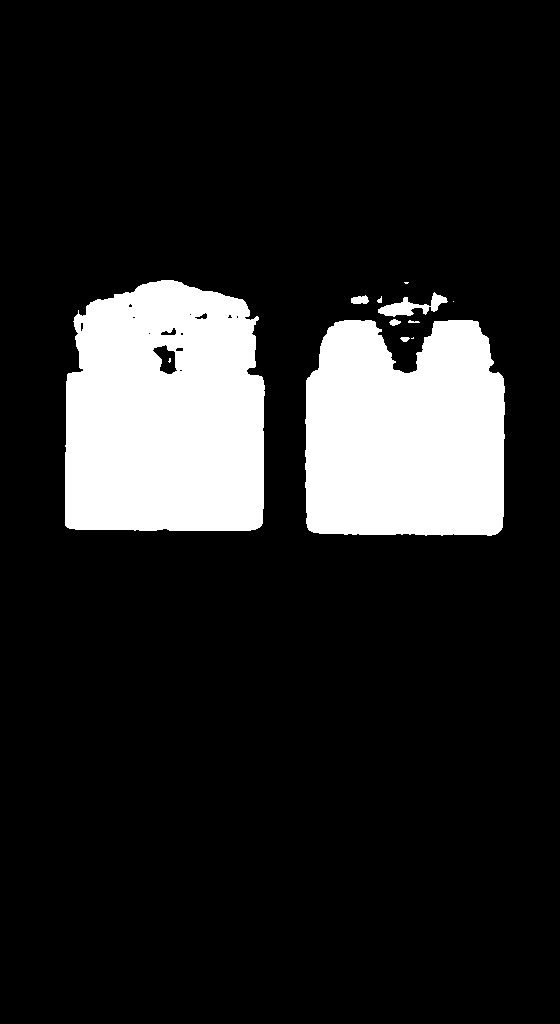

In [7]:
detect_prompt = 'window'
masks = groundingdino_sam.pred_mask_with_prompt(image_stage1, detect_prompt).cpu()
mask = torch.zeros_like(masks[0])
for m in masks:
    mask = mask | m
Image.fromarray(mask[0].numpy())

In [8]:
pipe2 = FluxFillPipeline.from_pretrained("/amax/hchuz/hfd_models/FLUX.1-Fill-dev", 
                                            torch_dtype=torch.bfloat16)
if offload:
    pipe2.enable_model_cpu_offload()
else:
    pipe2.to('cuda')

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

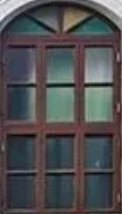

In [9]:
region_style_image = Image.open('temp/Snipaste_2023-02-21_13-33-51_window.png')
region_style_image

  0%|          | 0/20 [00:00<?, ?it/s]

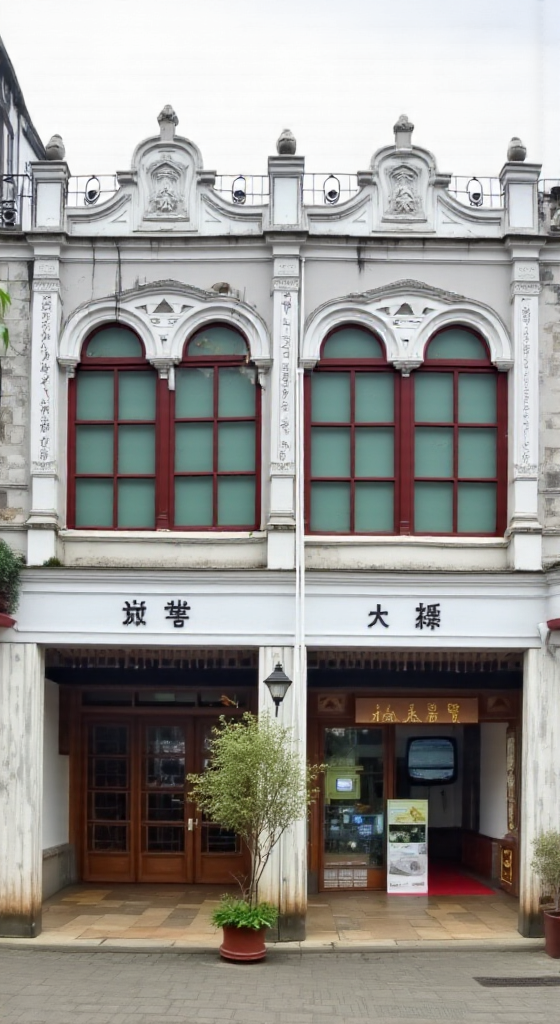

In [10]:
region_style_input = pipe_prior_redux(region_style_image)
image2 = pipe2(
    **region_style_input,
    image=image_stage1,
    mask_image=mask.float(),
    height=image_stage1.height,
    width=image_stage1.width,
    guidance_scale=30,
    num_inference_steps=20,
    generator=torch.Generator("cpu").manual_seed(seed),
).images[0]
image2